In [1]:
%matplotlib inline
#reads cdf files in python
from spacepy import pycdf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import time
from scipy import optimize
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import read_fmt_obs as rfo

In [3]:
#Time you are interested in reconstructing
date = '2019/02/09 00:10:00'

In [4]:
reload(rfo)
#Read in Wind spectra and parameters and format them in a way that can be used by the reconstruction program
fcs,vdf_inpt = rfo.fmt_wind_spec(date)

read_fmt_obs.py:201: RuntimeWarning: divide by zero encountered in divide
  cont  = 1.e12/(waeff*q0*dv*grid_v)


(<matplotlib.figure.Figure at 0x10e5529d0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e90e990>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x132bd2750>]], dtype=object))

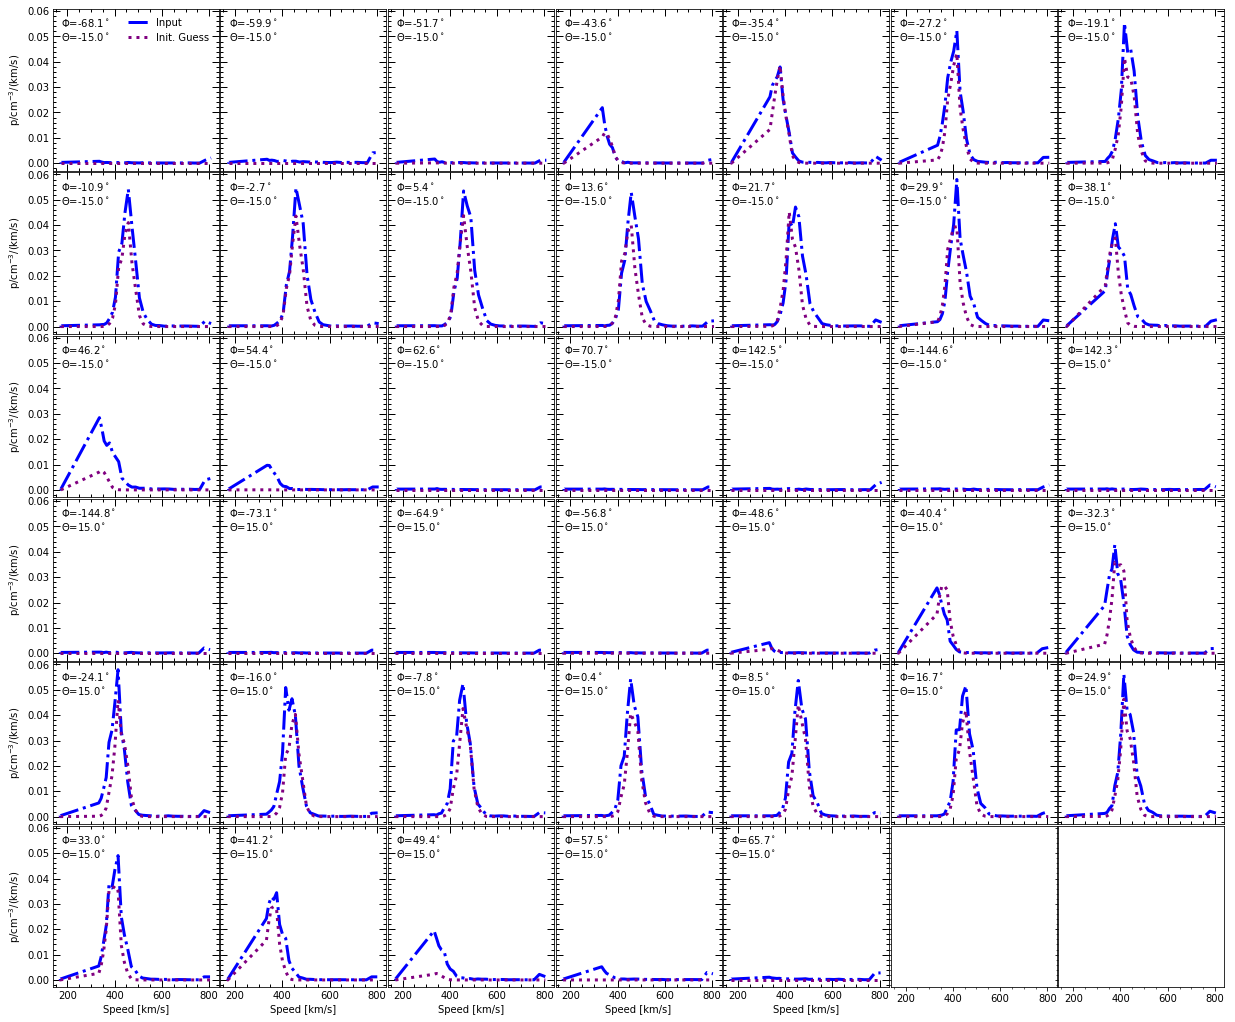

In [5]:
#Plot the Observations of all Wind FCs and the Velocity distribution if the bi-maxwellian solution 
#Derived by Wind for each FC
mff.create_fc_grid_plot(fcs)

In [6]:
#Trying a guess based on a previous failed try at fitting_wind_observation
human_guess = [ -4.35047381e+02,  -1.35264270e+01,   7.15811005e+00,   2.51430881e+01,
                 2.70190565e+01,   2.06592978e-02,   2.81259051e+00,   2.16901722e+00,
                 3.84810371e+01,   1.06937488e+01,   4.40914378e+01,   4.85236340e+01,
                 6.79767052e-03,   1.60664033e+00,   1.78231253e+00,]                


In [7]:
#Previous observation was at a different time so adjust velocity solution
human_guess[:3] = vdf_inpt['u_gse']

In [8]:
#Get magnetic fields from Wind CDF file that is stored in the vdf dictionary
b_gse = vdf_inpt['b_gse']
#Set the size of the VDF solution
vel_clip = 200. #km/s

(<matplotlib.figure.Figure at 0x10e552890>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x134abc690>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x136129e50>]], dtype=object))

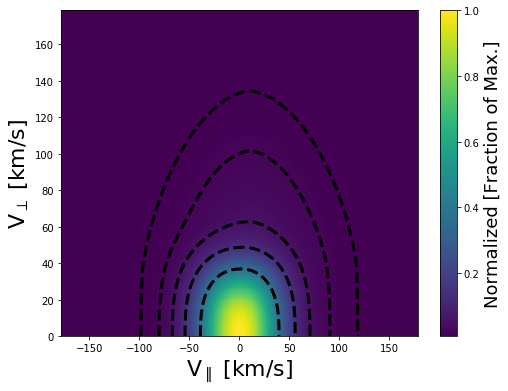

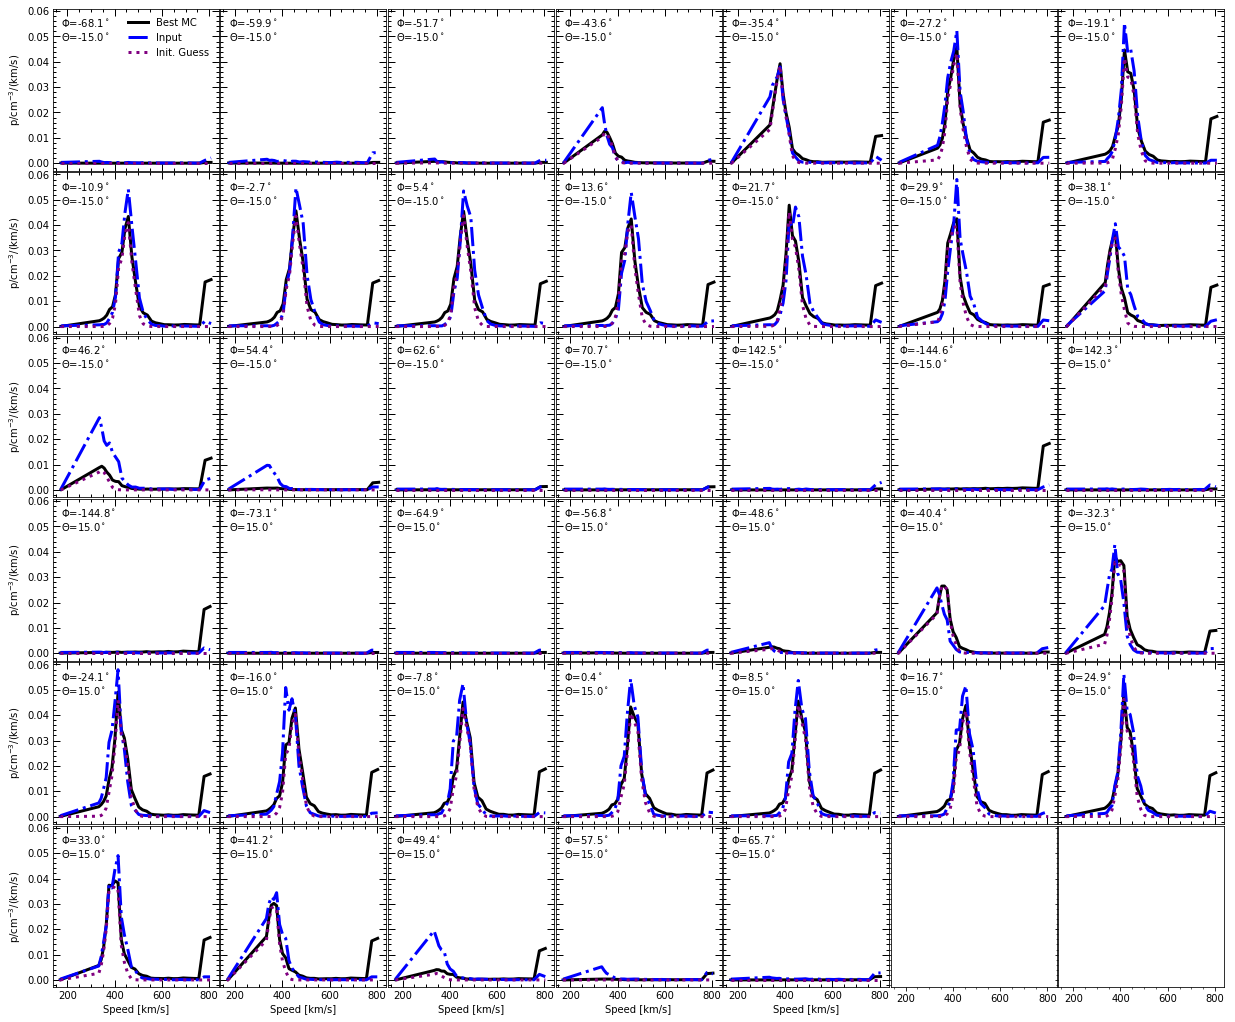

In [11]:
#Show what the initial guess assuming at generalized normal distribution
#looks like compared to the measurements and the bi-maxellian fit and Observations
dis_vdf_human = mdv.make_discrete_gennorm_vdf(human_guess,b_gse,pres=1.00,qres=1.00,clip=vel_clip,
                                                  add_ring=human_guess[8:])
#Plot what the velocity distribution looks like
mdv.plot_vdf(dis_vdf_human)
#measure the velocity distribution for each FC based on the input parameters
samp = 15.
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['dis_cur'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_human,samp)

mff.create_fc_grid_plot(fcs)

In [12]:
#maximum tries
max_try = 2200*3 #about 12 hours

In [13]:
#Notice NM can converge better than Powell with complex solutions, so trying it now
x1 = time.time()
#Try to minimize the sum squared errors for all FC to fit the best fit
#True means include ring in final fit
nm_human = optimize.minimize(mff.gennorm_2d_reconstruct,human_guess, args=(fcs,dis_vdf_human,True),method='Nelder-Mead',
                            options={'xtol':1e-1,'ftol':1e-1,'disp':True,'maxiter':max_try,'maxfev':max_try})
x2 = time.time()

Optimization terminated successfully.
         Current function value: 0.010149
         Iterations: 1872
         Function evaluations: 2481


(<matplotlib.figure.Figure at 0x13500bb50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1387001d0>)

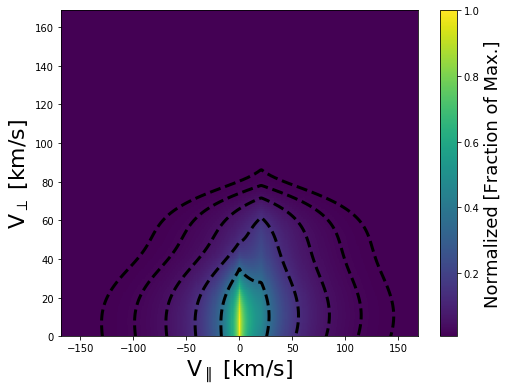

In [14]:
#Create Vper and Vpar velocity distribution and plot it
human_vdf =  mdv.make_discrete_gennorm_vdf(nm_human.x,b_gse,pres=1.00,qres=1.00,clip=vel_clip,
                                                  add_ring=nm_human.x[8:])
#Make the observations for the best fit solution
samp = 15.
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['dis_cur'] = mdv.arb_p_response(fcs[i]['x_meas'],human_vdf,samp)
    
#Plot the best fit 2D velocity distribution
mdv.plot_vdf(human_vdf)


(<matplotlib.figure.Figure at 0x1380b8110>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138e56990>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x139cef510>]], dtype=object))

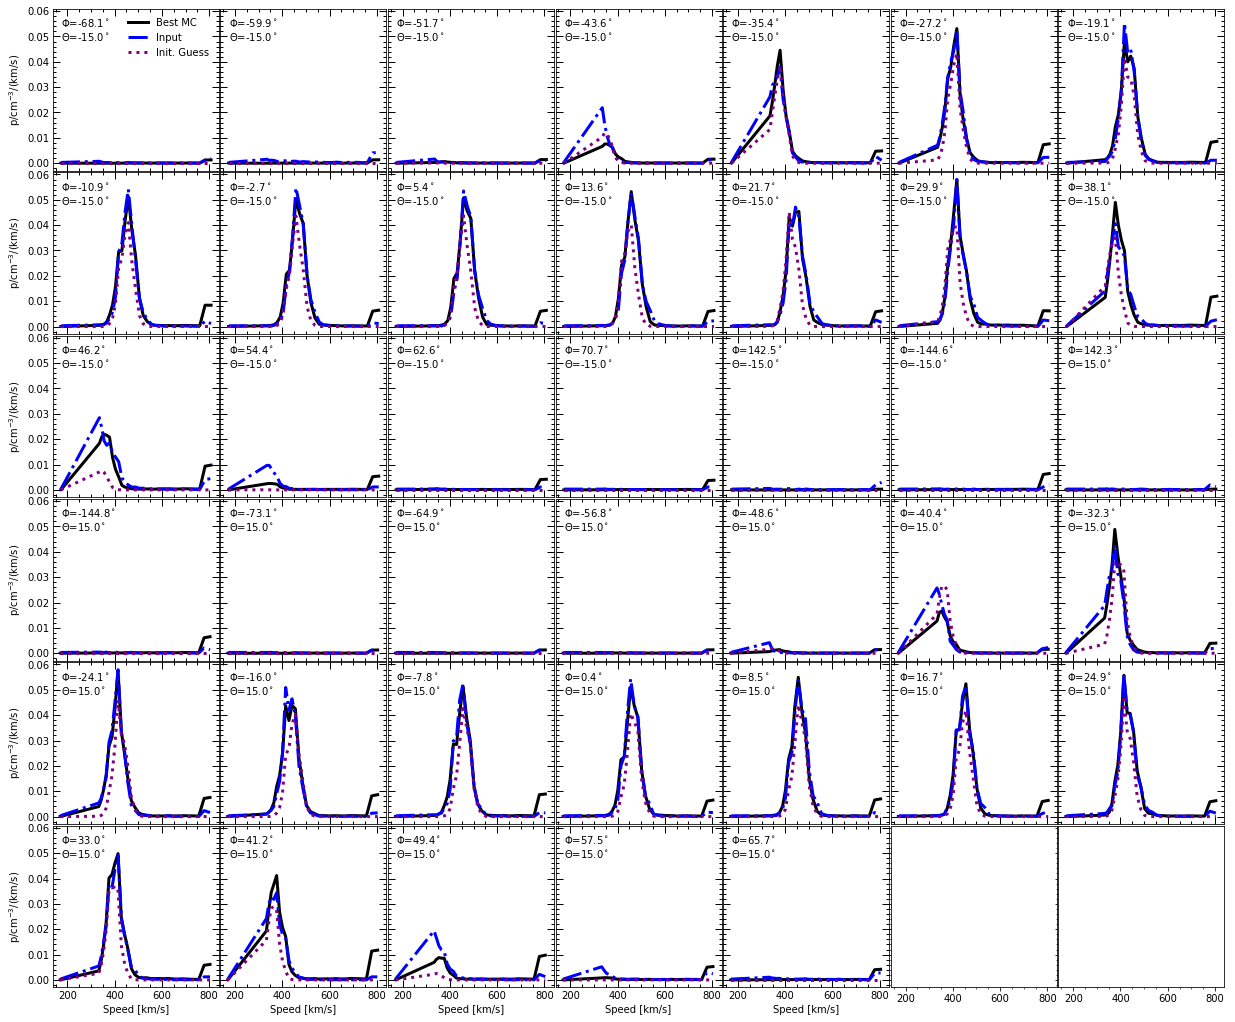

In [15]:
#Visually compare the best fit velocity solution (Best MC), the bi-maxwell (Init. Guess), and the observations (Input)
mff.create_fc_grid_plot(fcs)

In [16]:
#Total run time until convergence
print('Total Run Time {0:7.1f} min'.format((x2-x1)/60.))

Total Run Time   345.9 min


In [17]:
#The values of the final parameters S is the new parameter in the generalized normal (s=2 is a Guassian)
#[Vx,Vy,Vx,Wper,
# Wpar,Peak,Sper,Spar,
# Vper_ring,Vpar_ring,Wper_ring,Wpar_ring,
# Peak_ring,Sper_ring,Spar_ring]
print(nm_human.x)

[ -4.81881008e+02  -1.51928664e+01   1.15989788e+01   2.28466596e+01
   1.13188083e+01   1.64392408e-02   2.96678198e+00   7.77757718e-01
   3.15030573e+01   2.06082501e+01   2.53666094e+01   2.18549372e+01
   1.35222557e-02   4.12347011e+00   1.02747866e+00]
